## Using Earth Observations to Monitor Water Budgets for River Basin Management II

This Python Notebook presents the application of remotely sensed satellite imagery products to estimate the water budget components for the Limpopo River Basin, South Africa, based on the advanced-level webinar provided by [NASA's Applied Remote Sensing Training (ARSET)](https://arset.gsfc.nasa.gov/water/webinars/water-budgets-river-basin).

### Required Packages

In [1]:
%matplotlib inline
import os
import time
import geopandas as gpd
from glob import glob
import rasterio as rio
import earthpy.spatial as es
from json import dumps
import folium
from pathlib import Path
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterstats import zonal_stats
from selenium import webdriver
from IPython.display import display

### List of Abbreviations

- PR: Precipitation
- ET: Evapotranspiration
- TWS: Total Water Storage
- IMERG: Integrated Multi-satellitE Retrievals for GPM
- MODIS: Moderate Resolution Imaging Spectroradiometer
- GRACE: Gravity Recovery and Climate Experiment 
- W: Wet
- D: Dry
- BCM: Billions of Cubic Meters
- sqm: Square Meter
- cum: Cubic Meter

### Limpopo River Basin Shapefile

#### Reading shapefile and converting shp to geojson

In [2]:
# Reading shapefile as geopandas
gpd_shapefile = gpd.read_file("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp")

# Writing geopandas as geojson
gpd_shapefile.to_file("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.json", driver="GeoJSON")

In [3]:
bbox_extent = gpd_shapefile.total_bounds
lon_center, lat_center = np.array(bbox_extent).reshape(2, 2).mean(axis=0)

my_map = folium.Map(location=[lat_center, lon_center],tiles='Stamen Terrain',zoom_start=7.0)

folium.GeoJson(
    './data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.json',
    name='Limpopo River Basin',
    style_function=lambda feature: {
        'fillColor': 'None',
        'color' : 'blue',
        'weight' : 5,
    }
).add_to(my_map)
my_map

In [4]:
## Saving map
my_map.save('./data/Limpopo_River_Basin.html')

## Creating image (png) from folium map
delay=5

tem_url = 'file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile='data/Limpopo_River_Basin.html')

## Open a browser window
browser = webdriver.Safari()
# # set window size
# browser.set_window_size(480, 320) 
# maximize window
browser.maximize_window()
## Display the map
browser.get(tem_url)
## Giving the map tiles some time to load
time.sleep(delay)
## Grabbing the screenshot
browser.save_screenshot('./data/Limpopo_River_Basin.png')
#Close the browser
browser.quit()

<div align="center">
  <img width="800" height="500" src="./data/Limpopo_River_Basin.png">
</div>

### IMERG Precipitation

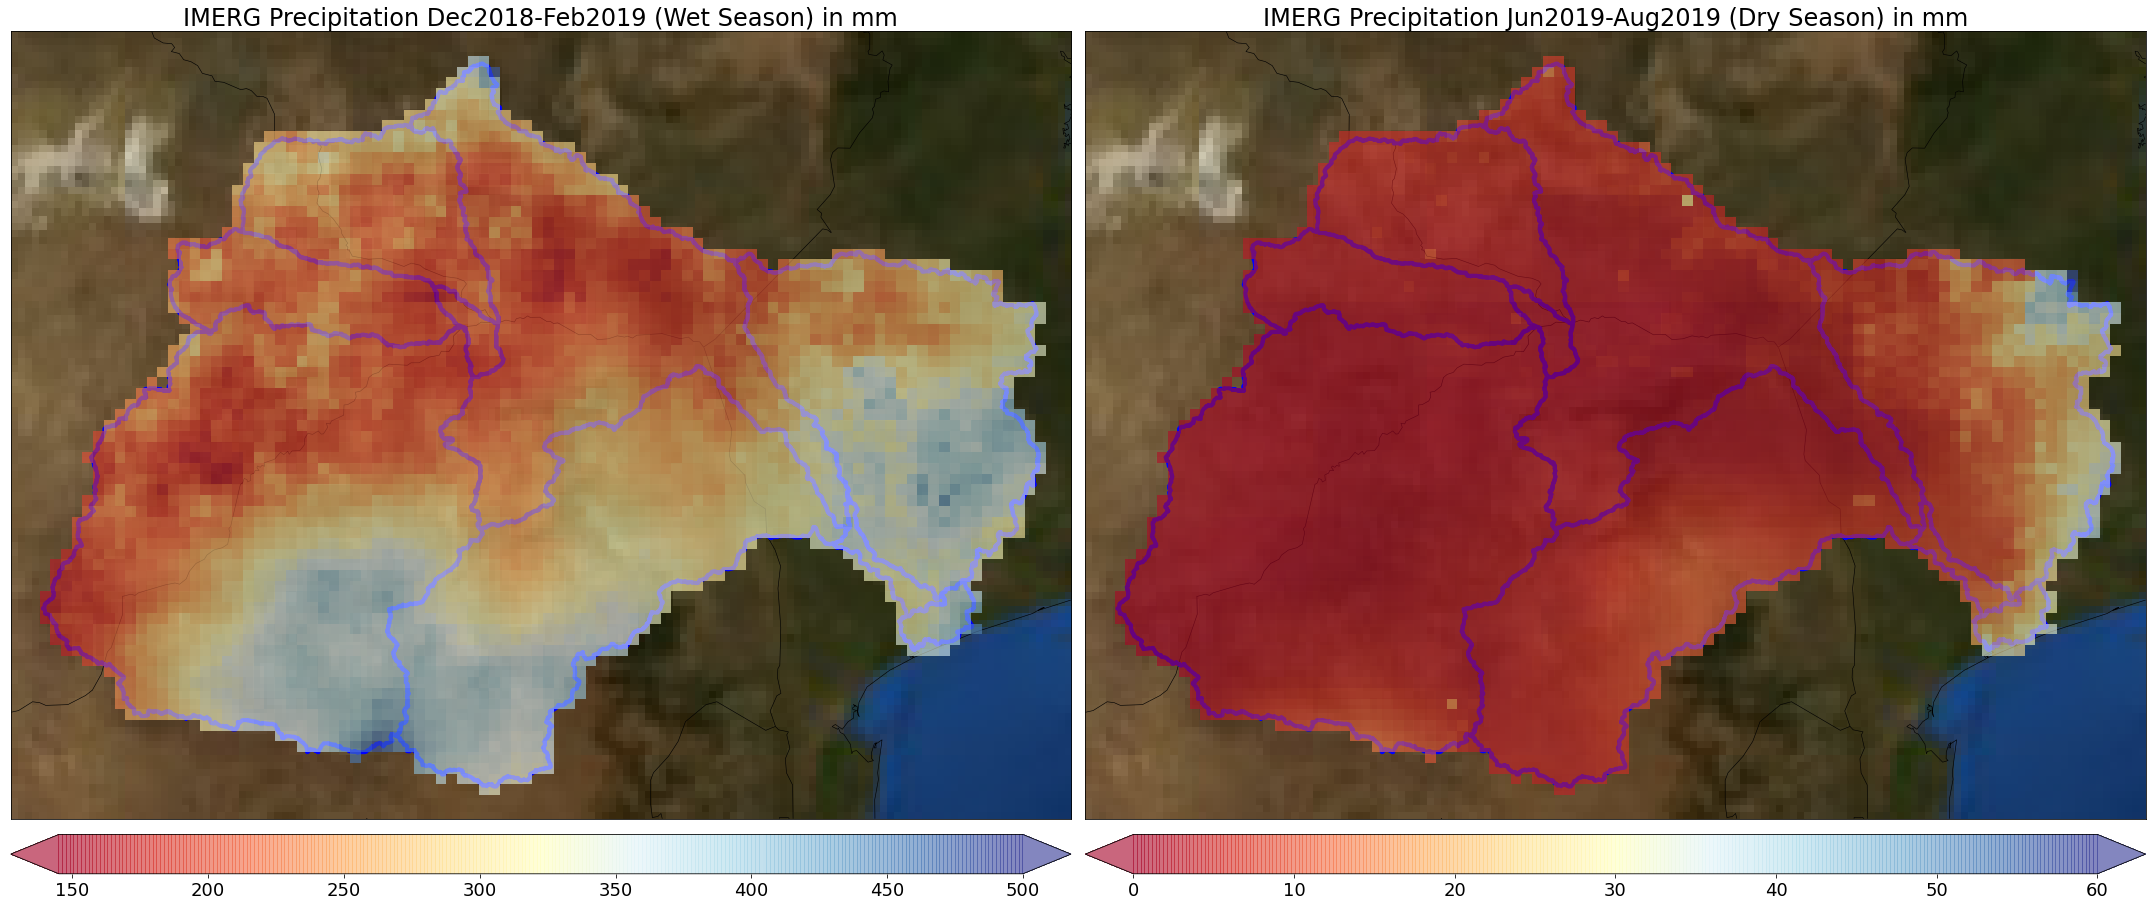

In [5]:
fig, axes = plt.subplots(1,2, figsize=(30,20))
axes = axes.ravel()

imgerg_filename = sorted(glob("./data/IMERG Precipitation/*.tif"))

for i, ax in enumerate(axes):
    
    if i == 0:
        vmin = 145
        vmax = 500
        title_name = 'IMERG Precipitation Dec2018-Feb2019 (Wet Season) in mm'
    elif i == 1:
        vmin = 0
        vmax = 60
        title_name = 'IMERG Precipitation Jun2019-Aug2019 (Dry Season) in mm'
        
    dataset = rio.open(imgerg_filename[i])   
    
    # Grab limits of image's extent
    image_extent = dataset.bounds
    
    # Grab limits of image's extent
    left, bottom, right, top =  dataset.bounds
    
    # Grab CRS
    crs = dataset.crs
    
    # load the geotiff image, assign it a variable
    image = dataset.read(1)
    image_mod = ma.masked_where(image == -9999.9, image)
    
    n_add = 0.3 # for zooming in and out
    m = Basemap(ax = axes[i],llcrnrlon=bbox_extent[0]-n_add,llcrnrlat=bbox_extent[1]-n_add,urcrnrlon=bbox_extent[2]+n_add,\
            urcrnrlat=bbox_extent[3]+n_add,resolution='i', projection='cyl')
    m.bluemarble()
    m.drawcoastlines(color='black',linewidth=0.6)
    m.drawcountries(color='black',linewidth=0.6)
    m.drawstates(color='black',linewidth=0.2)
    
    im = axes[i].imshow(image_mod, extent=(left, right, bottom, top),vmin=vmin, vmax=vmax,cmap = 'RdYlBu', zorder=10, alpha=0.6)
    m.readshapefile('./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04', \
                'Limpopo_River_Sub-basins_lev04',linewidth=4, color='b',drawbounds=True)
    ax.set_title(title_name,fontsize=24)  
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad="2%")
    cb = fig.colorbar(im, ax=ax,extend='both', cax=cax, orientation="horizontal")
    cb.ax.tick_params(labelsize=18)
    
plt.tight_layout()  
plt.savefig('./output/fig_01_IMERG_Precipitation_Wet_Dry.png',dpi=100,bbox_inches='tight')
plt.show()       

### MODIS ET 

In [6]:
modis_ET_files = sorted(list(Path("./data/MODIS ET").glob("MOD16A2GF.006_ET_500m_*.tif")))

#### Wet Season

In [7]:
wet_modis_ET = modis_ET_files[:13]
MODIS_ET_DJF19 = np.empty((1621, 2234,13))
MODIS_ET_DJF19[:] = np.nan
for i in range(13):  
    
    file = wet_modis_ET[i]
    tif_file = "./data/MODIS ET/" + f"{file.stem}.tif"
    
    dataset = rio.open(tif_file) 
    # Grab limits of image's extent
    left, bottom, right, top =  dataset.bounds
    # load the geotiff image, assign it a variable
    image = dataset.read(1)
    image[(image >= 32760) & (image <= 32767)] = 0    
    MODIS_ET_DJF19[:,:,i] = image 
    del image

ET_DJF19 = np.sum(MODIS_ET_DJF19,axis = 2) * 0.1

#### Dry Season

In [8]:
dry_modis_ET = modis_ET_files[13:]
MODIS_ET_JJA19 = np.empty((1621, 2234,13))
MODIS_ET_JJA19[:] = np.nan
for i in range(13):  
    
    file = dry_modis_ET[i]
    tif_file = "./data/MODIS ET/" + f"{file.stem}.tif"
    
    dataset = rio.open(tif_file) 
    # Grab limits of image's extent
    left, bottom, right, top =  dataset.bounds
    # load the geotiff image, assign it a variable
    image = dataset.read(1)
    image[(image >= 32760) & (image <= 32767)] = 0     
    MODIS_ET_JJA19[:,:,i] = image 
    del image

ET_JJA19 = np.sum(MODIS_ET_JJA19,axis = 2) * 0.1

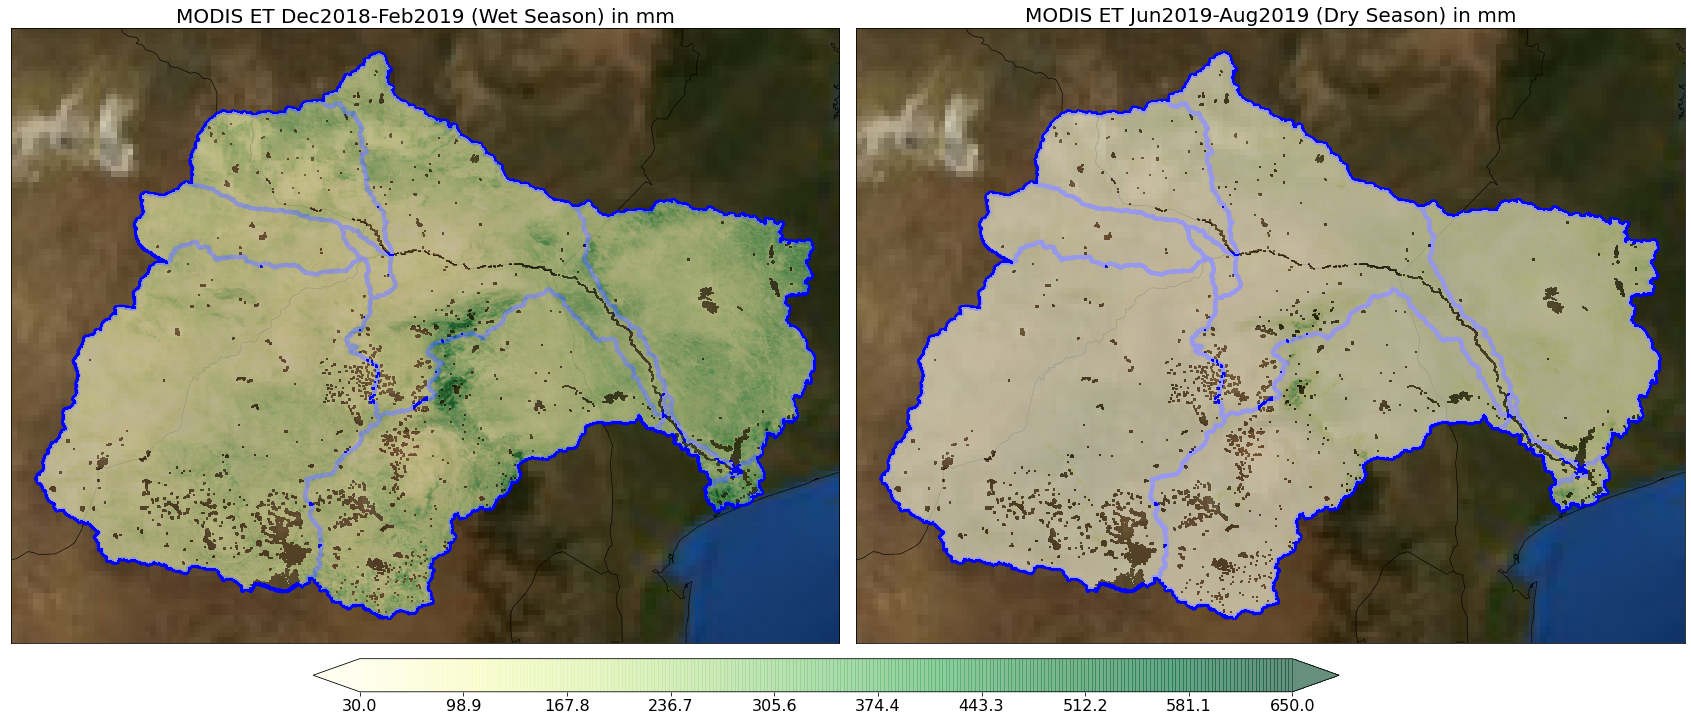

In [9]:
fig, axes = plt.subplots(1,2, figsize=(30,20))#(width,height)
fig.subplots_adjust(hspace=0, wspace=0.02)
axes = axes.ravel()

for i, ax in enumerate(axes):
    
    if i == 0:
        data_plot = ma.masked_where(ET_DJF19 == 0, ET_DJF19)
        title_name = 'MODIS ET Dec2018-Feb2019 (Wet Season) in mm'
    elif i == 1:
        data_plot = ma.masked_where(ET_JJA19 == 0, ET_JJA19)
        title_name = 'MODIS ET Jun2019-Aug2019 (Dry Season) in mm'
        
    n_add = 0.3 # for zooming in and out
    m = Basemap(ax = axes[i],llcrnrlon=bbox_extent[0]-n_add,llcrnrlat=bbox_extent[1]-n_add,urcrnrlon=bbox_extent[2]+n_add,\
            urcrnrlat=bbox_extent[3]+n_add,resolution='i', projection='cyl')
    m.bluemarble()
    m.drawcoastlines(color='black',linewidth=0.6)
    m.drawcountries(color='black',linewidth=0.6)
    m.drawstates(color='black',linewidth=0.2)
    
    im = axes[i].imshow(data_plot, extent=(left, right, bottom, top),vmin=30, vmax=650,cmap = 'YlGn', zorder=10, alpha=0.6)
    m.readshapefile('./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04', \
                'Limpopo_River_Sub-basins_lev04',linewidth=4, color='b',drawbounds=True)
    ax.set_title(title_name,fontsize=20) 
    
p0 = axes[0].get_position().get_points().flatten()
p1 = axes[1].get_position().get_points().flatten() 
ticks = np.linspace(30, 650, 10)
ax_cbar = fig.add_axes([p0[0]+0.14, 0+0.255, p1[2]-p0[0]-0.3, 0.023])
cb=plt.colorbar(im, cax=ax_cbar,extend='both', orientation='horizontal',ticks=ticks)
cb.ax.tick_params(labelsize=16)   
 
plt.savefig('./output/fig_02_MODIS_ET_Wet_Dry.png',dpi=100,bbox_inches='tight')    
plt.show()   

### GRACE TWS

In [10]:
files_path = sorted(glob("./data/GRACE/*.tif"))

#### Clipping the images 

In [11]:
# Create output directory for cropped GRACE
output_dir = os.path.join("./data", "GRACE_cropped")

#Check the availability of the folder
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)

# Open the crop boundary using GeoPandas.
crop_bound = gpd.read_file("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp")

# The crop function won’t work properly if the data are in different Coordinate Reference Systems (CRS). To fix this, be sure to reproject 
# the crop layer to match the CRS of your raster data. To reproject your data, first get the CRS of the raster from the rasterio profile object. 
# Then use that to reproject using geopandas .to_crs method.
with rio.open(files_path[0]) as raster_crs:
    crop_raster_profile = raster_crs.profile
    geo_crop_bound_WGS84 = crop_bound.to_crs(crop_raster_profile["crs"]) 
    
# Crop each image
image_paths_list = es.crop_all(files_path, output_dir, geo_crop_bound_WGS84, overwrite=True)

#### Process GRACE TWS

#### Wet Season

In [12]:
## March
dataset_Mar = rio.open(image_paths_list[2])  
image_extent = dataset_Mar.bounds
left, bottom, right, top =  dataset_Mar.bounds
GRFO_TWS_Mar19 = dataset_Mar.read(1)

## December
dataset_Dec = rio.open(image_paths_list[0])  
image_extent = dataset_Dec.bounds
left, bottom, right, top =  dataset_Dec.bounds
GRFO_TWS_Dec18 = dataset_Dec.read(1)

DTWS_DJF19 = (GRFO_TWS_Mar19 - GRFO_TWS_Dec18) * 1000

#### Dry Season

In [13]:
## September
dataset_Sep = rio.open(image_paths_list[3])  
image_extent = dataset_Sep.bounds
left, bottom, right, top =  dataset_Sep.bounds
GRFO_TWS_Sep19 = dataset_Sep.read(1)

## June
dataset_Jun = rio.open(image_paths_list[1])  
image_extent = dataset_Jun.bounds
left, bottom, right, top =  dataset_Jun.bounds
GRFO_TWS_Jun19 = dataset_Jun.read(1)

DTWS_JJA19 = (GRFO_TWS_Sep19 - GRFO_TWS_Jun19 ) * 1000

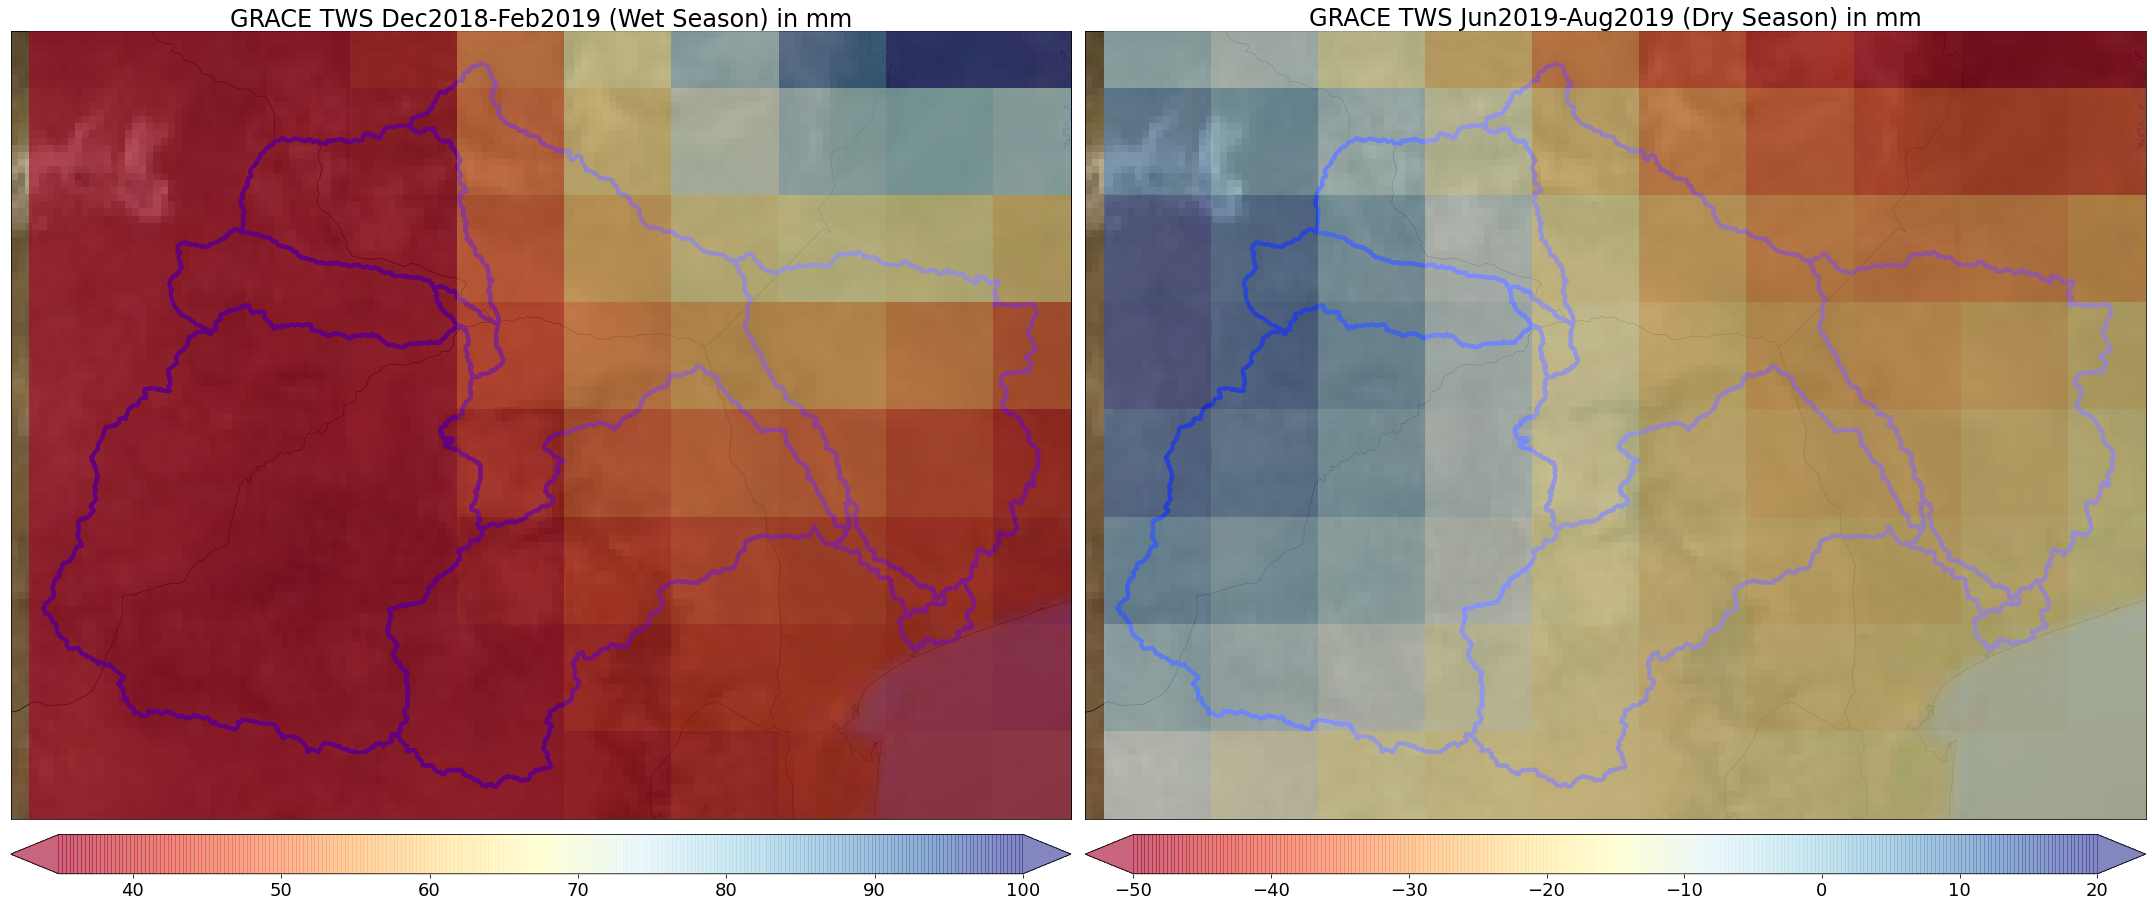

In [14]:
fig, axes = plt.subplots(1,2, figsize=(30,20))#(width,height)
fig.subplots_adjust(hspace=0, wspace=0.02)
axes = axes.ravel()

for i, ax in enumerate(axes):
    
    if i == 0:
        vmin = 35
        vmax = 100
        data_plot = DTWS_DJF19
        title_name = 'GRACE TWS Dec2018-Feb2019 (Wet Season) in mm'
    elif i == 1:
        vmin = -50
        vmax = 20
        data_plot = DTWS_JJA19
        title_name = 'GRACE TWS Jun2019-Aug2019 (Dry Season) in mm'
        
    n_add = 0.3 # for zooming in and out
    m = Basemap(ax = axes[i],llcrnrlon=bbox_extent[0]-n_add,llcrnrlat=bbox_extent[1]-n_add,urcrnrlon=bbox_extent[2]+n_add,\
            urcrnrlat=bbox_extent[3]+n_add,resolution='i', projection='cyl')
    m.bluemarble()
    m.drawcoastlines(color='black',linewidth=0.6)
    m.drawcountries(color='black',linewidth=0.6)
    m.drawstates(color='black',linewidth=0.2)
    
    im = axes[i].imshow(data_plot, extent=(left, right, bottom, top),vmin=vmin, vmax=vmax,cmap = 'RdYlBu', zorder=10, alpha=0.6)
    m.readshapefile('./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04', \
                'Limpopo_River_Sub-basins_lev04',linewidth=4, color='b',drawbounds=True)     
    ax.set_title(title_name,fontsize=24)  
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad="2%")
    cb = fig.colorbar(im, ax=ax,extend='both', cax=cax, orientation="horizontal")
    cb.ax.tick_params(labelsize=18)
    
plt.tight_layout()  
plt.savefig('./output/fig_03_GRACE_TWS_Wet_Dry.png',dpi=100,bbox_inches='tight') 
plt.show()  

### Zonal Statistics

#### IMERG Precipitation

In [23]:
### Wet Season
IMERG_wet = rio.open(imgerg_filename[0])
IMERG_wet_data = IMERG_wet.read(1)
IMERG_wet_data_mod = ma.masked_where(IMERG_wet_data == -9999.9, IMERG_wet_data)
IMERG_wet_affine = IMERG_wet.transform
zonal_stat_IMERG_wet = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 IMERG_wet_data_mod,affine=IMERG_wet_affine, stats=['mean'],geojson_out=False))
df_zonal_stat_IMERG_wet = zonal_stat_IMERG_wet.rename(columns={'mean': 'PRW Mean (mm)'})

### Dry Season
IMERG_dry = rio.open(imgerg_filename[1])
IMERG_dry_data = IMERG_dry.read(1)
IMERG_dry_data_mod = ma.masked_where(IMERG_dry_data == -9999.9, IMERG_dry_data)
IMERG_dry_affine = IMERG_dry.transform
zonal_stat_IMERG_dry = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 IMERG_dry_data_mod,affine=IMERG_dry_affine, stats=['mean'],geojson_out=False))
df_zonal_stat_IMERG_dry = zonal_stat_IMERG_dry.rename(columns={'mean': 'PRD Mean (mm)'})

#### MODIS ET

In [16]:
### Wet Season
ET_wet = ma.masked_where(ET_DJF19 == 0, ET_DJF19)
ET_wet_dummy = rio.open(modis_ET_files[0])
ET_wet_affine = ET_wet_dummy.transform
zonal_stat_ET_wet = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 ET_wet,affine=ET_wet_affine, stats=['mean'],geojson_out=False))
df_zonal_stat_ET_wet = zonal_stat_ET_wet.rename(columns={'mean': 'ETW Mean (mm)'})

### Dry Season
ET_dry = ma.masked_where(ET_JJA19 == 0, ET_JJA19)
ET_dry_dummy = rio.open(modis_ET_files[0])
ET_dry_affine = ET_dry_dummy.transform
zonal_stat_ET_dry = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 ET_dry,affine=ET_dry_affine, stats=['mean'],geojson_out=False))
df_zonal_stat_ET_dry = zonal_stat_ET_dry.rename(columns={'mean': 'ETD Mean (mm)'})

#### GRACE TWS

In [17]:
### Wet Season
GRACE_wet = DTWS_DJF19 
GRACE_wet_dummy = rio.open(image_paths_list[0])
GRACE_wet_affine = GRACE_wet_dummy.transform
zonal_stat_GRACE_wet = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 GRACE_wet,affine=GRACE_wet_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_GRACE_wet = zonal_stat_GRACE_wet.rename(columns={'mean': 'TWSW Mean (mm)'})

### DRY Season
GRACE_dry = DTWS_JJA19 
GRACE_dry_dummy = rio.open(image_paths_list[0])
GRACE_dry_affine = GRACE_dry_dummy.transform
zonal_stat_GRACE_dry = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 GRACE_dry,affine=GRACE_dry_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_GRACE_dry = zonal_stat_GRACE_dry.rename(columns={'mean': 'TWSD Mean (mm)'})

### Merging Zonal Statistics into Geopandas Dataframe

In [18]:
### Merging all dataframes
df = pd.concat([gpd_shapefile,df_zonal_stat_IMERG_wet, df_zonal_stat_IMERG_dry,\
                                          df_zonal_stat_ET_wet,df_zonal_stat_ET_dry,\
                                          df_zonal_stat_GRACE_wet,df_zonal_stat_GRACE_dry], axis=1, sort=False)

df_copy = df.copy()
df_copy = df_copy.to_crs("EPSG:6933") # epsg 6933. It is cylindrical equal-area projection

df_copy["Area (sqm)"] = df_copy['geometry'].area  

df_copy["PRW (cum)"] = df_copy["PRW Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["PRD (cum)"] = df_copy["PRD Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["ETW (cum)"] = df_copy["ETW Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["ETD (cum)"] = df_copy["ETD Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["TWSW (cum)"] = df_copy["TWSW Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["TWSD (cum)"] = df_copy["TWSD Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy.to_csv("./output/Limpopo_RS.csv",index=False, encoding='utf-8-sig')

In [19]:
pd.options.display.max_columns = None
display(df_copy)

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,PEWcount,PEWsum,PEWmean,Area,geometry,PRW Mean (mm),PRD Mean (mm),ETW Mean (mm),ETD Mean (mm),TWSW Mean (mm),TWSD Mean (mm),Area (sqm),PRW (cum),PRD (cum),ETW (cum),ETD (cum),TWSW (cum),TWSD (cum)
0,1040012590,0,1040012590,1040012590,0.0,0.0,2666.7,407139.0,1241,0,0,1,40,0.139966,8.450522,60.375423,2.947817e+09,"POLYGON ((3256353.200 -3051640.451, 3256357.22...",354.350588,21.855489,315.927303,141.036630,41.160908,-20.577984,2.661081e+09,9.429556e+08,5.815923e+07,8.407081e+08,3.753099e+08,1.095325e+08,-5.475968e+07
1,1041584690,1040012590,1040012590,1040012590,97.0,97.0,64544.4,64544.4,1242,0,0,2,41,4.000000,271.491245,67.872811,7.023703e+10,"POLYGON ((3049496.124 -2693864.766, 3049602.40...",317.408168,15.130514,222.183632,77.774854,51.478571,-25.344783,6.438675e+10,2.043688e+10,9.742046e+08,1.430568e+10,5.007670e+09,3.314538e+09,-1.631868e+09
2,1041584780,1040012590,1040012590,1040012590,97.2,97.2,2422.9,345110.5,1243,0,0,1,42,0.215343,12.953776,60.154166,2.668536e+09,"POLYGON ((3202540.452 -3083343.832, 3202540.45...",335.445870,10.432543,208.788528,88.988060,44.230813,-23.169763,2.417664e+09,8.109952e+08,2.522238e+07,5.047804e+08,2.151432e+08,1.069352e+08,-5.601669e+07
3,1041576130,1041584780,1040012590,1040012590,258.7,258.7,81485.4,81485.7,1244,0,0,2,43,5.000000,359.419754,71.883951,8.976130e+10,"POLYGON ((3135804.108 -3004375.346, 3135804.10...",316.997413,5.084809,189.518201,46.295279,40.412495,-19.276547,8.130868e+10,2.577464e+10,4.134391e+08,1.540947e+10,3.764208e+09,3.285887e+09,-1.567351e+09
4,1041576090,1041584780,1040012590,1040012590,258.9,258.9,77221.4,261202.8,1245,0,0,1,44,8.000000,451.838230,56.479779,8.353545e+10,"POLYGON ((2825590.379 -2476707.381, 2825787.19...",225.858881,2.951107,165.930076,53.521972,47.557981,-21.799635,7.702232e+10,1.739618e+10,2.273011e+08,1.278032e+10,4.122386e+09,3.663026e+09,-1.679058e+09
5,1041548260,1041576090,1040012590,1040012590,788.8,788.8,2565.2,155088.5,1247,0,0,1,45,0.224211,15.170820,67.663155,2.778429e+09,"POLYGON ((2837902.718 -2799512.348, 2837936.80...",197.495767,0.764033,101.474547,33.839020,39.291282,-10.198582,2.558705e+09,5.053334e+08,1.954935e+06,2.596434e+08,8.658406e+07,1.005348e+08,-2.609516e+07
6,1041548220,1041576090,1040012590,1040012590,789.0,789.0,29066.7,29066.7,1246,0,0,2,46,4.000000,297.376728,74.344182,3.122996e+10,"POLYGON ((2604325.514 -2660685.912, 2604270.77...",237.797962,3.870173,171.025573,42.538232,32.178184,-5.786079,2.898728e+10,6.893116e+09,1.121858e+08,4.957566e+09,1.233068e+09,9.327580e+08,-1.677227e+08
7,1041548760,1041548260,1040012590,1040012590,828.1,828.1,133110.8,133110.8,1249,0,0,1,47,13.000000,672.616299,51.739715,1.461870e+11,"POLYGON ((2743024.542 -3212254.031, 2742622.51...",265.453226,2.026247,127.454931,30.999480,20.906763,-2.152452,1.328130e+11,3.525565e+10,2.691121e+08,1.692768e+10,4.117136e+09,2.776691e+09,-2.858738e+08
8,1041548750,1041548260,1040012590,1040012590,828.3,828.3,19497.6,19497.6,1248,0,0,2,48,1.699644,107.515039,63.257390,2.106204e+10,"POLYGON ((2575940.573 -2772351.664, 2575863.76...",219.721554,2.068072,134.028957,38.916326,25.559328,1.799239,1.944676e+10,4.272871e+09,4.021728e+07,2.606428e+09,7.567963e+08,4.970460e+08,3.498935e+07


### Calculating Seasonal Water Budget Components in BCM

In [20]:
PRW_Basin_BCM = sum(df_copy["PRW (cum)"].to_numpy()) * (10 ** -9) #BCM indicates billions of cubic meters
PRD_Basin_BCM = sum(df_copy["PRD (cum)"].to_numpy()) * (10 ** -9)
ETW_Basin_BCM = sum(df_copy["ETW (cum)"].to_numpy()) * (10 ** -9)
ETD_Basin_BCM = sum(df_copy["ETD (cum)"].to_numpy()) * (10 ** -9)
TWSW_Basin_BCM = sum(df_copy["TWSW (cum)"].to_numpy()) * (10 ** -9)
TWSD_Basin_BCM = sum(df_copy["TWSD (cum)"].to_numpy()) * (10 ** -9)

#### Water budget of whole basin in BCM

| PRW | PRD | ETW | ETD | TWSW | TWSD | 
| :---: | :---: | :---: | :---: | :---: | :---: | 
| 112.289 | 2.122 | 68.592 | 19.678 | 14.787 | -5.434 

### Examine Seasonal Water Budget Components

In [21]:
PR_ET_Wet_Season = PRW_Basin_BCM - ETW_Basin_BCM
PR_ET_Dry_Season = PRD_Basin_BCM - ETD_Basin_BCM
PR_ET_TWS_Wet_Season = PRW_Basin_BCM - ETW_Basin_BCM - TWSW_Basin_BCM
PR_ET_TWS_Dry_Season = PRD_Basin_BCM - ETD_Basin_BCM - TWSD_Basin_BCM

#### Water budget for wet and dry seasons

$$
Wet \:Season: PRW - ETW = 43.696339 \:BCM
$$

$$
Wet \:Season: PRW - ETW - TWSW = 28.909392 \:BCM
$$

$$
Dry \:Season: PRD - ETD = -17.556504 \:BCM
$$

$$
Dry \:Season: PRD - ETD - TWSD = -12.122749 \:BCM
$$